Тут мы оценим обе модели DeepLabv3 и UNet на новых изображениях, которые не являлись частью обучающей и валидационной выборки

In [1]:
from config import *
from scripts.data_processing import create_masks, slice_images


In [1]:
create_masks(TEST_ANNOTATIONS_PATH, RAW_TEST_IMAGES_DIR, RAW_TEST_MASKS_DIR, COLOR_MAPPING)
slice_images(RAW_TEST_IMAGES_DIR, RAW_TEST_MASKS_DIR, TEST_IMAGES_DIR, TEST_MASKS_DIR, 4, 7)

Processing images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]

Created 28 image-mask pairs


Для теста я выбрал одну область с различным ландшавтом, на нём видно несколько поселений леса и различные поля

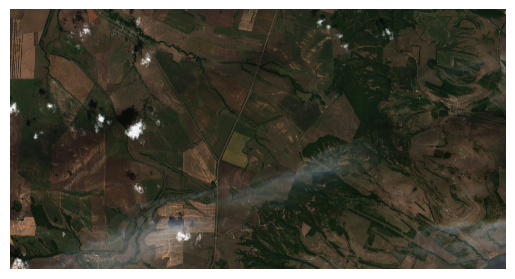

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread(RAW_TEST_IMAGES_DIR + 'IMG_TEST.png')

plt.imshow(image)
plt.axis('off')
plt.show()

Посмотрим на нарезанное изображение

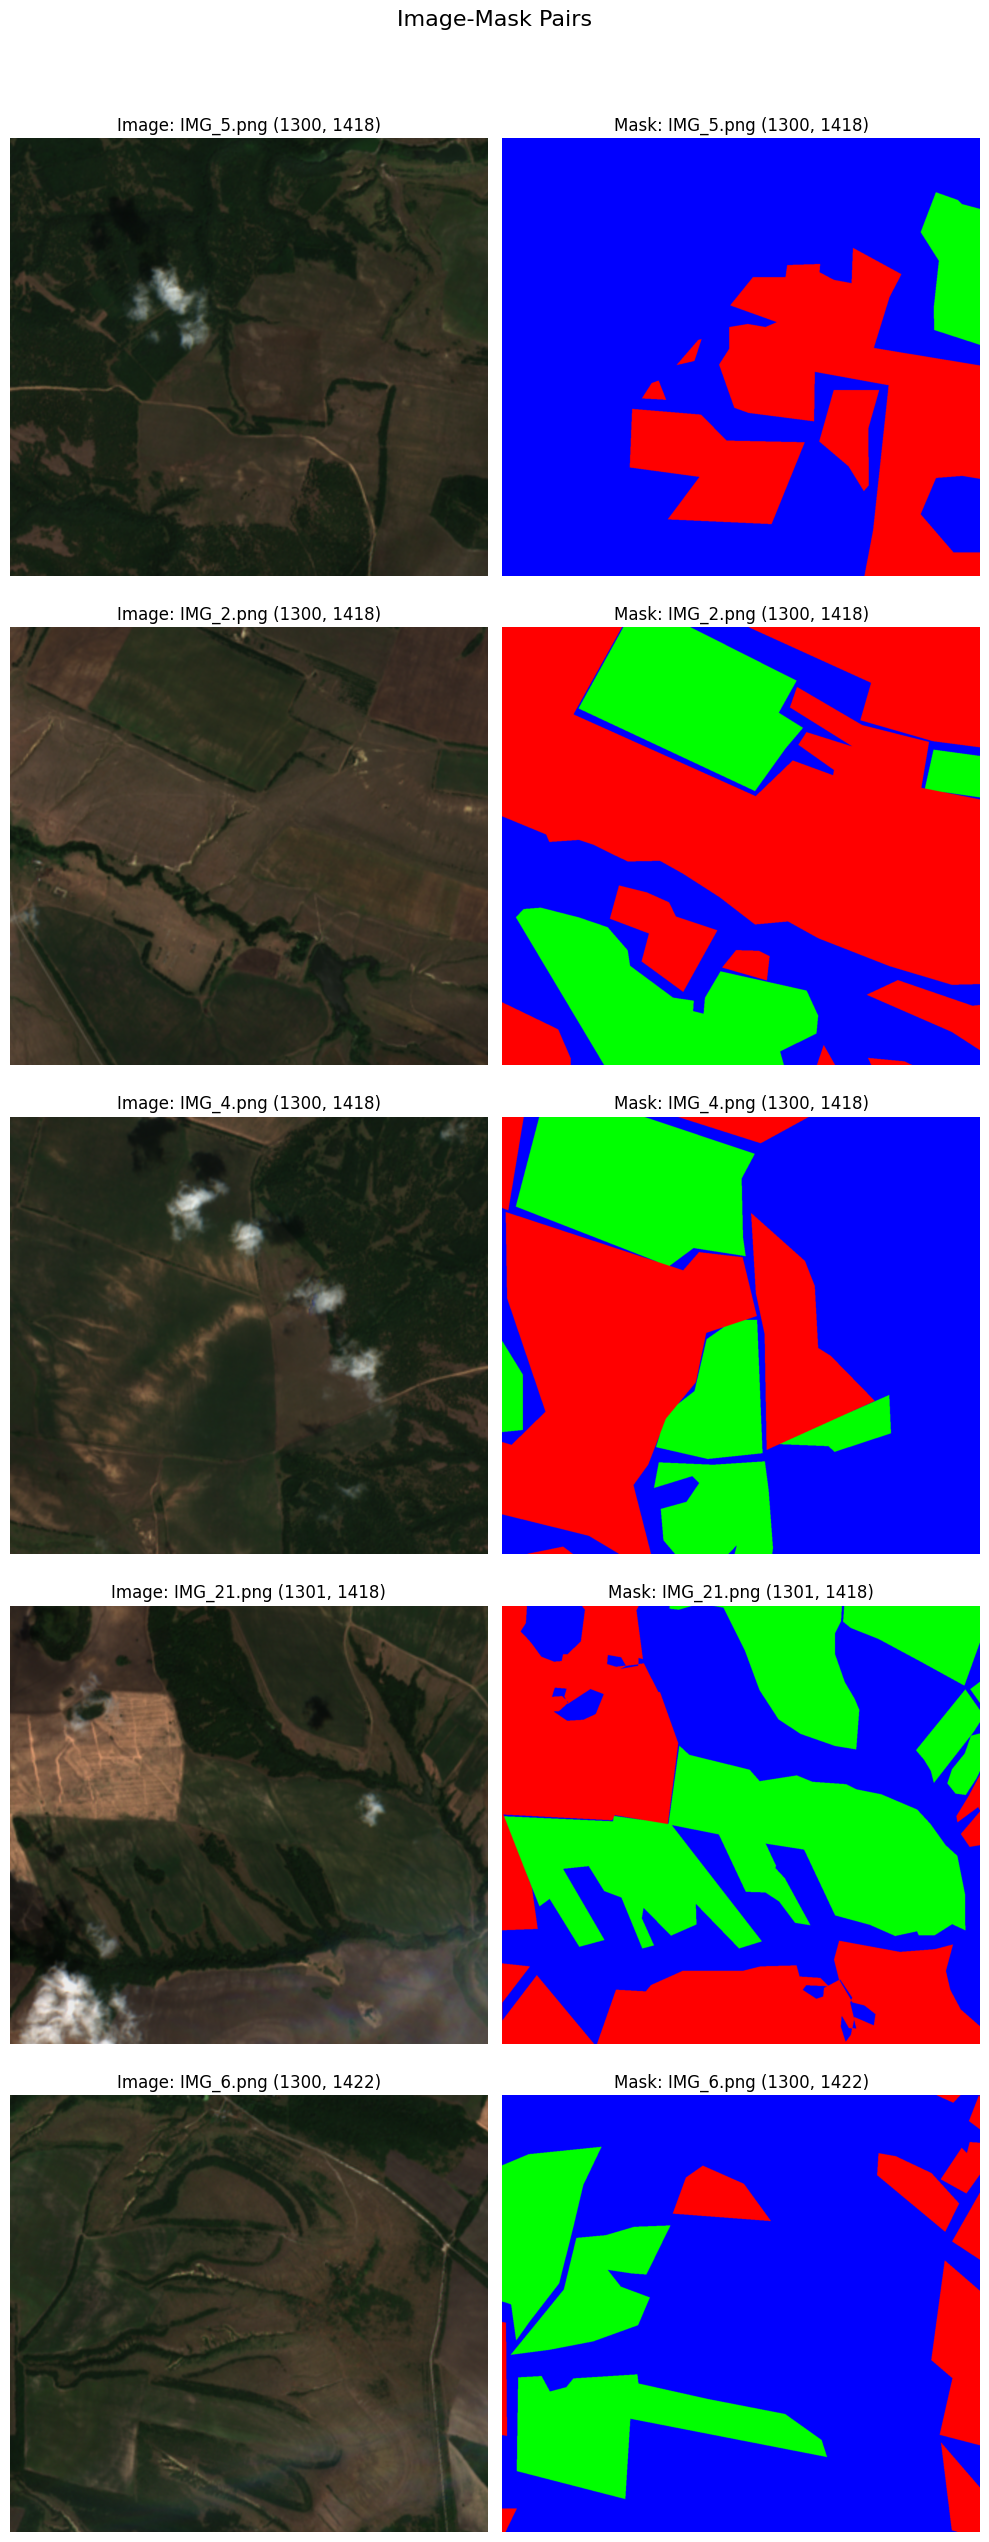

In [3]:
import os
import random
import cv2

NUM_PAIRS_TO_SHOW = 5

valid_pairs = []
for img_name in os.listdir(TEST_IMAGES_DIR):
    img_path = os.path.join(TEST_IMAGES_DIR, img_name)
    mask_path = os.path.join(TEST_MASKS_DIR, img_name)
    
    if os.path.isfile(img_path) and os.path.isfile(mask_path):
        valid_pairs.append((img_path, mask_path))

selected_pairs = random.sample(valid_pairs, min(NUM_PAIRS_TO_SHOW, len(valid_pairs)))

fig, axes = plt.subplots(NUM_PAIRS_TO_SHOW, 2, figsize=(10, 5*NUM_PAIRS_TO_SHOW))
plt.suptitle("Image-Mask Pairs", y=1.02, fontsize=16)

for idx, (img_path, mask_path) in enumerate(selected_pairs):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Image: {os.path.basename(img_path)} {img.shape[:2]}")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(mask)
    axes[idx, 1].set_title(f"Mask: {os.path.basename(mask_path)} {img.shape[:2]}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [3]:
from src.models.DeepLabv3.model import get_model
from src.models.unet.model import UNet
import torch

In [4]:
unet = UNet().to('cuda')
DeepLabv3 = get_model().to('cuda')

In [5]:
DeepLabv3.load_state_dict(torch.load(SAVE_DIR + 'DeepLabv3_epoch_24.pth'))
unet.load_state_dict(torch.load(SAVE_DIR + 'UNet_1.0_epoch_25.pth'))

<All keys matched successfully>

In [6]:
from src.big_image import process_image
from src.data.utils import show_image_mask, show_pair

In [7]:
from PIL import Image
from torchvision import transforms

image = Image.open(RAW_TEST_IMAGES_DIR + 'IMG_TEST.png')
mask = Image.open(RAW_TEST_MASKS_DIR + 'IMG_TEST.png')

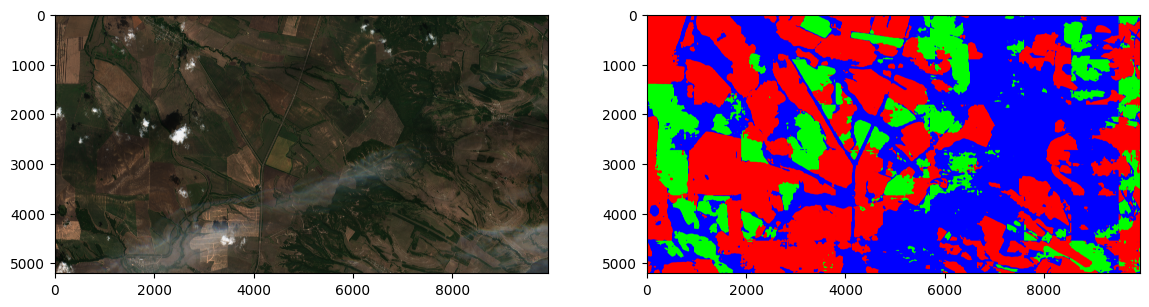

In [8]:
show_image_mask(image, process_image(image, (22, 12), DeepLabv3))

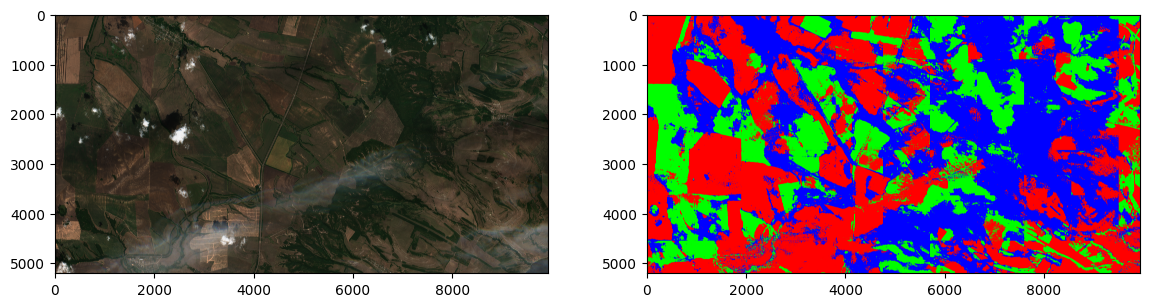

In [9]:
show_image_mask(image, process_image(image, (22, 12), unet))

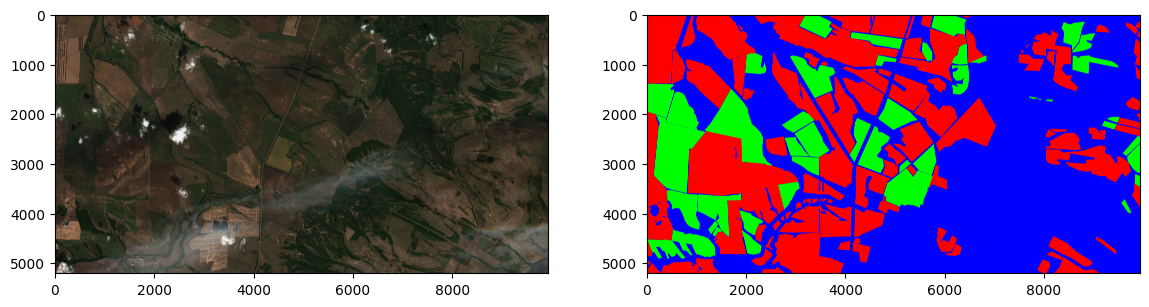

In [10]:
show_pair(image, mask)

Визуально результат DeepLabv3 мне нравится больше, давайте сравним метрики

In [15]:
from torchvision import transforms as T
from src.data.dataset import SatelliteDataset
from torch.utils.data import Dataset, DataLoader

def paired_transform_func(image, mask):
    crop = T.CenterCrop(512)
    return crop(image), crop(mask)

test_dataset = SatelliteDataset(
    TEST_IMAGES_DIR,
    TEST_MASKS_DIR,
    paired_transform=paired_transform_func
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Загрузили датасет, теперь посчитаем метрики на обеих сетях

In [26]:
from tqdm import tqdm

def evaluate_model(model, dataloader, device, num_classes=3):
    model.eval()
    total_tp = torch.zeros(num_classes, device=device)
    total_fp = torch.zeros(num_classes, device=device)
    total_fn = torch.zeros(num_classes, device=device)
    total_accuracy = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            
            if isinstance(outputs, dict):
                outputs = outputs['out']
            
            preds = outputs.argmax(dim=1)
            masks = masks.argmax(dim=1)

            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            correct = (preds_flat == masks_flat).sum().item()
            total_accuracy += correct
            total_pixels += masks_flat.numel()

            for cls in range(num_classes):
                tp = ((preds_flat == cls) & (masks_flat == cls)).sum().item()
                fp = ((preds_flat == cls) & (masks_flat != cls)).sum().item()
                fn = ((preds_flat != cls) & (masks_flat == cls)).sum().item()
                total_tp[cls] += tp
                total_fp[cls] += fp
                total_fn[cls] += fn

    epsilon = 1e-8
    iou = total_tp / (total_tp + total_fp + total_fn + epsilon)
    dice = 2 * total_tp / (2 * total_tp + total_fp + total_fn + epsilon)
    precision = total_tp / (total_tp + total_fp + epsilon)
    recall = total_tp / (total_tp + total_fn + epsilon)
    accuracy = total_accuracy / total_pixels

    metrics = {
        'iou': iou.cpu().numpy(),
        'dice': dice.cpu().numpy(),
        'precision': precision.cpu().numpy(),
        'recall': recall.cpu().numpy(),
        'accuracy': accuracy,
        'mean_iou': iou.mean().item(),
        'mean_dice': dice.mean().item(),
        'mean_precision': precision.mean().item(),
        'mean_recall': recall.mean().item()
    }
    return metrics

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

metrics_unet = evaluate_model(unet, test_loader, device)
metrics_deeplab = evaluate_model(DeepLabv3, test_loader, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


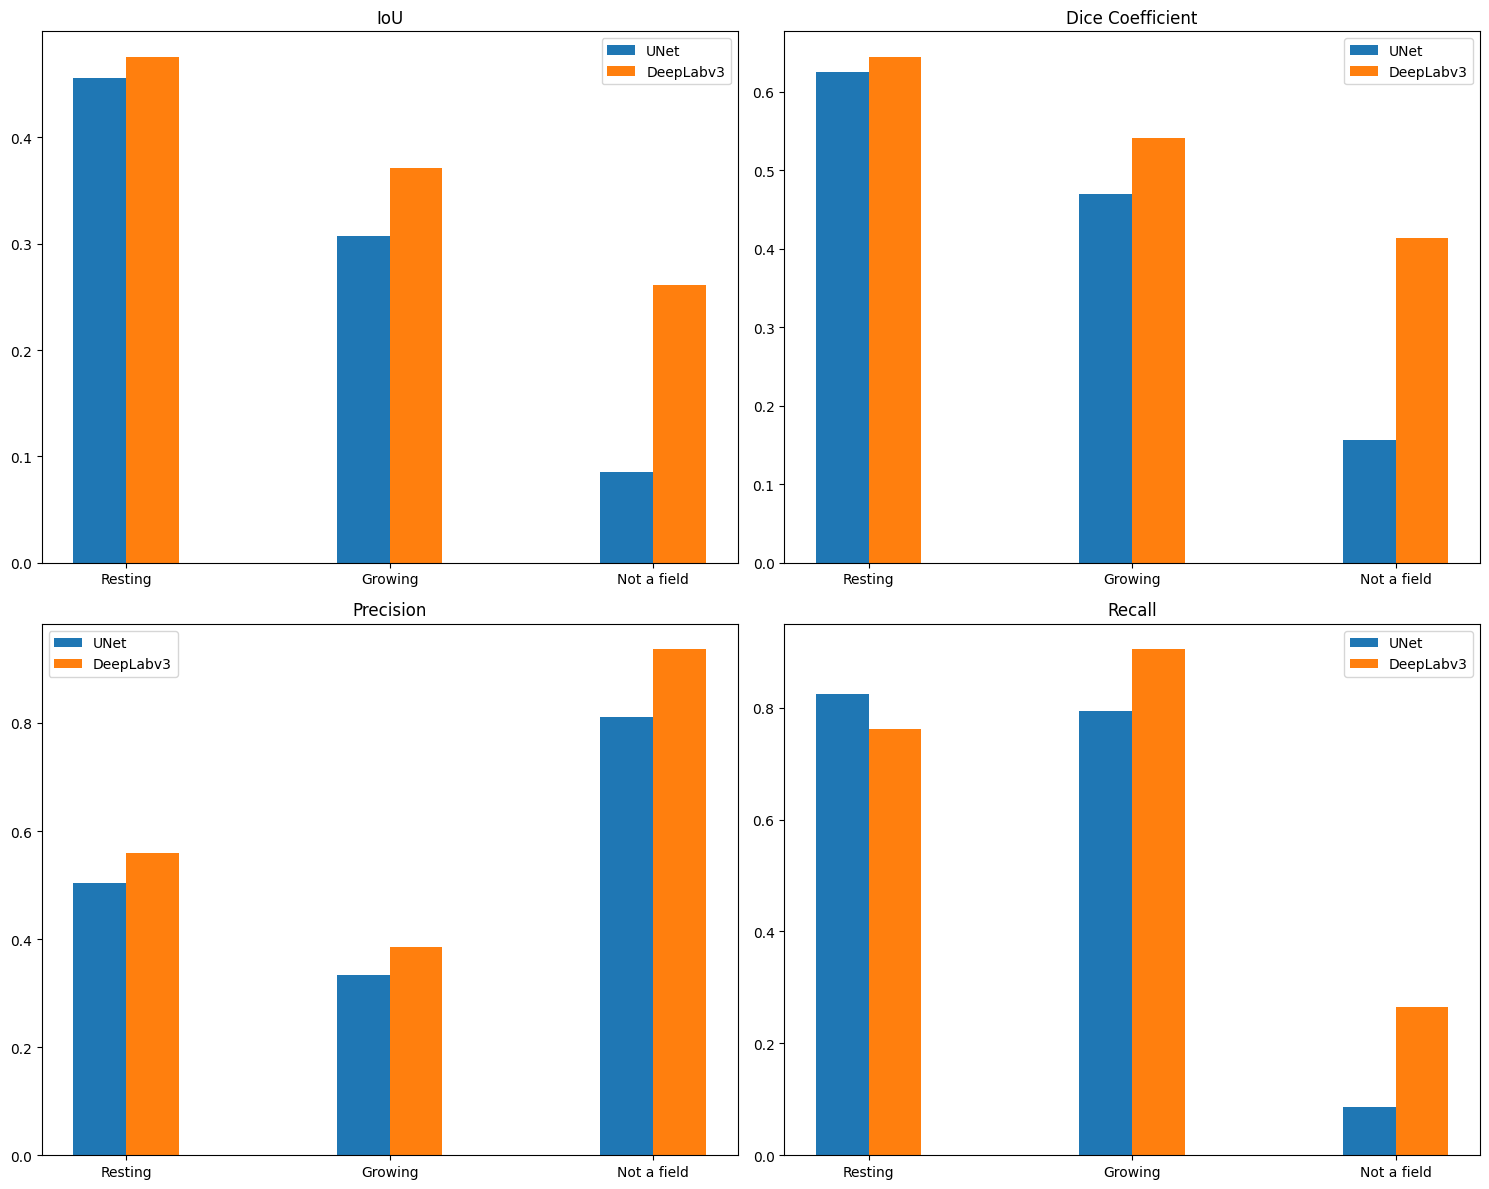

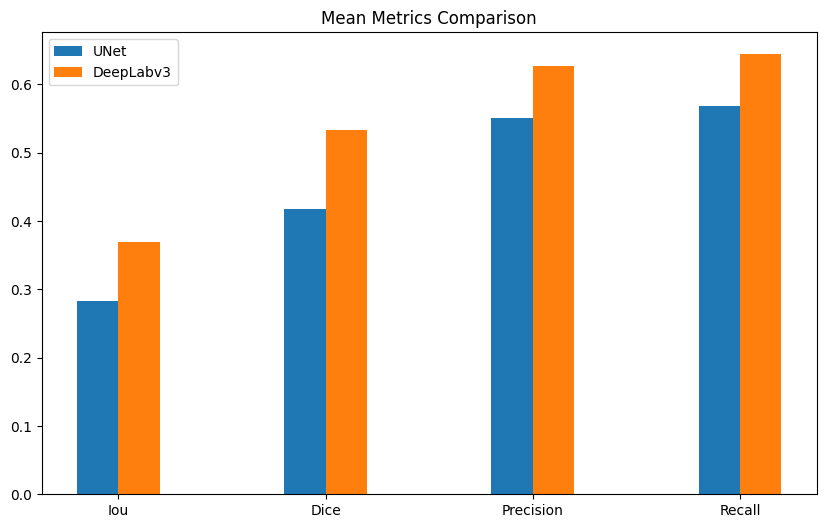

UNet Accuracy: 0.4460
DeepLabv3 Accuracy: 0.5379


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(metrics_unet, metrics_deeplab, class_names=['Resting', 'Growing', 'Not a field']):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics = ['iou', 'dice', 'precision', 'recall']
    titles = ['IoU', 'Dice Coefficient', 'Precision', 'Recall']
    
    for ax, metric, title in zip(axes.flatten(), metrics, titles):
        ax.bar(np.arange(3)-0.1, metrics_unet[metric], width=0.2, label='UNet')
        ax.bar(np.arange(3)+0.1, metrics_deeplab[metric], width=0.2, label='DeepLabv3')
        ax.set_xticks(range(3))
        ax.set_xticklabels(class_names)
        ax.set_title(title)
        ax.legend()

    plt.tight_layout()
    plt.show()

    mean_metrics = ['mean_iou', 'mean_dice', 'mean_precision', 'mean_recall']
    values_unet = [metrics_unet[m] for m in mean_metrics]
    values_deeplab = [metrics_deeplab[m] for m in mean_metrics]
    
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(4)-0.1, values_unet, width=0.2, label='UNet')
    plt.bar(np.arange(4)+0.1, values_deeplab, width=0.2, label='DeepLabv3')
    plt.xticks(range(4), [m.replace('mean_', '').title() for m in mean_metrics])
    plt.title('Mean Metrics Comparison')
    plt.legend()
    plt.show()

    print(f"UNet Accuracy: {metrics_unet['accuracy']:.4f}")
    print(f"DeepLabv3 Accuracy: {metrics_deeplab['accuracy']:.4f}")

plot_comparison(metrics_unet, metrics_deeplab)

Как видим по всем метрикам DeepLabv3 превосходит UNet при этом стоит заметит, что DeepLabv3 отлично отличает поле от не поля (в сравнении с UNet)
Поэтому для Api и UI мы будем использовать DeepLabv3